In [2]:
import numpy as np
from scipy import stats
from scipy import special
from sklearn import cluster
from matplotlib import pyplot
import matplotlib
import seaborn as sns
import time
import pandas as pd
# to avoid "RuntimeWarning: divide by zero encountered in log"
np.seterr(divide = 'ignore', invalid = 'ignore')
# numpy.seterr(divide = 'warn')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

In [3]:
# observed data
Y = np.array([267, 333, 159, 145, 340, 463, 305, 329, 575,227, 532, 769, 526, 565, 466, 494, 440, 858, 599, 298, 529, 912, 703, 402, 
    669, 796, 483, 700, 418, 979, 757, 755, 517, 710, 240, 490, 497, 250, 271, 303, 386, 326, 144, 145, 138, 413, 531, 331, 329, 529, 318, 449, 
    852, 332, 742, 479, 620, 531, 751, 442, 824, 660, 834, 955, 453, 953, 808, 975, 627, 851, 721, 1112, 731, 748, 675, 272, 292, 389, 323, 
    272, 248, 290, 1973.497, 1973.75, 1974.163, 1974.413, 1974.665, 1975.002, 1975.245, 1975.497, 1975.75, 1976.078, 1976.33, 1976.582, 1976.917, 
    1977.245, 1977.497, 1977.665, 1978.002, 1978.33, 1978.582, 1978.832, 1979.078, 1979.582, 1979.832, 1980.163, 1980.497, 1980.75, 1980.917, 
    1981.163, 1981.497, 1981.665, 1981.917, 1982.163, 1982.413, 1982.665, 1982.917, 1983.163, 1983.413, 1983.665, 1983.917, 1984.163, 1984.413]).reshape((3, 41))
# print(Y)
# data = pd.DataFrame(data=Y.transpose(), columns=["firstcount", "secondcount", "time"])
# data.to_csv("data.csv")

In [4]:
# logarithm of the density of the negative binomial so that E(Y|mu) = mu and V(Y|mu) = mu + tau*mu^2
def logdnegbin(y, mu, tau):
    loggamma = special.gammaln
    s = loggamma(y + 1/tau) - loggamma(1/tau) - loggamma(y + 1) - (y + 1/tau) * np.log(1 + mu * tau) + y * np.log(mu * tau)
    s[np.isnan(s)] = -np.inf
    return(s)

In [5]:
# logarithm of the density of the priors on the Metropolis-Hastings parameters
def prior(p):
    # r, sigma, tau, b
    rmax = 10 # r ~ U(-rmax,+rmax)
    smax = 10 # s ~ U(0,smax)
    taumax = 10 # tau ~ U(0,taumax)
    bmax = 10 # s ~ U(0,bmax)
    return(
        np.log( (abs(p[0]) < rmax)/(2 * rmax) )
        + np.log( ((p[1] > 0) & (p[1] < smax))/smax )
        + np.log( ((p[2] > 0) & (p[2] < taumax))/taumax )
        + np.log( ((p[3] > 0) & (p[3] < bmax))/bmax )
        )

In [6]:
# random number from a mixture
def mixturerandom(mixture):
    if "composition" not in mixture.keys():
        random = stats.multivariate_normal.rvs(mean=mixture["m"].ravel(), cov=mixture["v"], size=1)
    else:
        choice = np.int(np.random.choice(len(mixture["w"]), size = 1, replace = True, p = mixture["w"]))
        random = stats.multivariate_normal.rvs(mean=mixture["composition"][choice]["m"].ravel(), cov=mixture["composition"][choice]["v"], size=1)
    return(random)

In [7]:
# logarithm of the density of the density of a mixture
def mixturedensity(x, mixture):
    if "composition" not in mixture.keys():
        density = stats.multivariate_normal.pdf(x = x, mean=mixture["m"].ravel(), cov=mixture["v"])
    else:
        density = 0
        for i in range(len(mixture["w"])):
            density = density + mixture["w"][i] * stats.multivariate_normal.pdf(x = x, mean=mixture["composition"][i]["m"].ravel(), cov=mixture["composition"][i]["v"])
    return(np.log(density))

In [8]:
# clustering in order to return a mixture (with the corresponding BIC)
def clustering(p, number):
    d = p.shape[0]
    n = p.shape[1]
    cholesky = np.linalg.cholesky(np.cov(p))
    choleskyinv = np.linalg.inv(cholesky)
    kmeans = cluster.KMeans(n_clusters = number, random_state = 20).fit(np.transpose( np.dot(choleskyinv, p)))
    labels = kmeans.labels_
    m = [ np.zeros((d, 1)) for i in range(number) ]
    v = [ np.zeros((d, d)) for i in range(number) ]
    likelihood = np.zeros((number, n))
    weights = []
    for i in range(number):
        m[i] = np.apply_along_axis(func1d = np.mean, axis = 1, arr = p[:, labels == i])
        v[i] = np.cov(p[:, labels == i])
        weights.append(np.sum(labels == i)/n)
        likelihood[i,:] = np.sum(labels == i)/n * stats.multivariate_normal.pdf(x = np.transpose(p), mean=m[i].ravel(), cov=v[i], allow_singular = True)
    loglikelihood = np.sum(np.log(likelihood))
    BIC = -2 * loglikelihood + (number * (d * (d + 1)/2 + d + 1)) * np.log(number)
    if number == 1:
        density = {"m" : m[0], "v" : v[0]}
    else:
        composition = []
        for i in range(number):
            composition.append({"m" : m[i], "v" : v[i]})
        density = {"w" : weights, "composition" : composition}
    return({"density" : density, "BIC" : BIC})

In [9]:
# proposed density using clustering
def proposeddensity(p):
    # p = Parameters[:,range(i)]
    BIC = np.array([np.nan for i in range(6)])
    densitylist = np.array([{} for i in range(6)])
    for i in range(6):
        c = clustering(p, i+1)
        BIC[i] = c["BIC"]
        densitylist[i] = c["density"]
    number = np.where(BIC == np.min(BIC))[0][0]
    density = densitylist[number]
    density_ = density.copy() # density with inflated variance (x 25)
    if (number == 0):
        density_["v"] = 25 * density_["v"]
    else:
        for i in range(number):
            density_["composition"][i]["v"] = 25 * density_["composition"][i]["v"]
    return( { "w" : [0.8, 0.2], "composition" : [ density, density_ ] } )


## Particle Filters

Three different models for the Particle Filters :

<br>
- (1) : density-dependent logistic diffusion model with environmental variance
$$ \frac{dx_{t}}{x_{t}} = (r+\frac{\sigma^2}{2}-bx_{t})dt + \sigma dW_{t} $$

<br>
- (2) : unregulated stochastic exponential growth model variance
$$ \frac{dx_{t}}{x_{t}} = (r+\frac{\sigma^2}{2})dt + \sigma dW_{t} $$
which has an explicit formula :
$$ x_{t_1} = x_{t_0} exp(r(t_1-t_0)+\sigma RW_{t_1-t_0})$$

<br>
- (3) : random-walk model variance
$$ \frac{dx_{t}}{x_{t}} = \frac{\sigma^2}{2}dt + \sigma dW_{t} $$
which has an explicit formula :
$$ x_{t_1} = x_{t_0} exp(\sigma RW_{t_1-t_0})$$

<br>
where $RW_{t_1-t_0}$ is a random normal variable with mean $0$ and variance $t_1-t_0$

In [10]:
def ParticleFilters(y, p, N, model):
    # initialization
    
    r = p[0]
    sigma = p[1]
    tau = p[2]
    # b = p[3]
    
    if np.min(p) < 0:
        return( -np.inf, np.nan )
    
    T = Y.shape[1]
    
    X = np.zeros((N, T))  # a matrix containing the log particles
    NL = np.zeros((1, T)) # normalized likelihood of the data at the parameter value
    I = np.zeros((N, T))  # index for the previous position of each particle
    
    t = 0 # drawing X[t+1] at time t = 0
#     print("{0} / {1}".format(t, T-1), end = "\r")
    
    X[:,t] = stats.norm.rvs(loc=5, scale=10, size=N)
    # 1 / compute weights
    weights = np.exp(logdnegbin(y = Y[1, t], mu = np.exp(X[:, t]), tau = tau) + logdnegbin(Y[2, t], mu = np.exp(X[:, t]), tau = tau))
    maxweights = np.max(weights)
    scaledweights = weights/maxweights
    NL[:,t] = np.mean(weights)
    # 2 / resample
    I[:,t] = np.random.choice(N, size = N, replace = True, p = scaledweights/np.sum(scaledweights))
    # 3 / project the particles using the choosen model
    if model == "1": # (1) : density-dependent logistic diffusion model with environmental variance
        b = p[3]
        delta = y[2,t+1] - y[2,t]
        dt = delta/10
        x = X[I[:,t].astype(int),t]
        for _ in range(10):
            x += ( (r + sigma*sigma/2 - b*np.exp(x) )*dt + np.sqrt(dt) * stats.norm.rvs(loc=0, scale=1, size=N) )
        X[:,t+1] = x
    elif model == "2": # (2) : unregulated stochastic exponential growth model
        delta = y[2,t+1] - y[2,t]
        X[:,t+1] = X[I[:,t].astype(int),t] + r * delta + sigma * np.sqrt(delta) * stats.norm.rvs(loc=0, scale=1, size=N)
    elif model == "3": # (3) : random-walk model
        delta = y[2,t+1] - y[2,t]
        X[:,t+1] = X[I[:,t].astype(int),t] + sigma * np.sqrt(delta) * stats.norm.rvs(loc=0, scale=1, size=N)
    
    # loop on the time
    for t in range(1, T-1):
        
#         print("{0} / {1}".format(t, T-1), end = "\r")
        
        # drawing X[t+1] at time t
        # 1 / compute weights
        weights = np.exp(logdnegbin(y = Y[1, t], mu = np.exp(X[:, t]), tau = tau) + logdnegbin(Y[2, t], mu = np.exp(X[:, t]), tau = tau))
        maxweights = np.max(weights)
        scaledweights = weights/maxweights
        NL[:,t] = np.mean(weights)
        # 2 / resample
        I[:,t] = np.random.choice(N, size = N, replace = True, p = scaledweights/np.sum(scaledweights))

        # 3 / project the particles using the choosen model
        if model == "1": # (1) : density-dependent logistic diffusion model with environmental variance
            b = p[3]
            delta = y[2,t+1] - y[2,t]
            dt = delta/10
            x = X[I[:,t].astype(int),t]
            for _ in range(10):
                x += ( (r + sigma*sigma/2 - b*np.exp(x) )*dt + np.sqrt(dt) * stats.norm.rvs(loc=0, scale=1, size=N) )
            X[:,t+1] = x
        elif model == "2": # (2) : unregulated stochastic exponential growth model
            delta = y[2,t+1] - y[2,t]
            X[:,t+1] = X[I[:,t].astype(int),t] + r * delta + sigma * np.sqrt(delta) * stats.norm.rvs(loc=0, scale=1, size=N)
        elif model == "3": # (3) : random-walk model
            delta = y[2,t+1] - y[2,t]
            X[:,t+1] = X[I[:,t].astype(int),t] + sigma * np.sqrt(delta) * stats.norm.rvs(loc=0, scale=1, size=N)
            
    t = T-1
#     print("{0} / {1}".format(t, T-1), end = "\r")
    # 1 / compute weights
    weights = np.exp(logdnegbin(y = Y[1, t], mu = np.exp(X[:, t]), tau = tau) + logdnegbin(Y[2, t], mu = np.exp(X[:, t]), tau = tau))
    maxweights = np.max(weights)
    scaledweights = weights/maxweights
    NL[:,t] = np.mean(weights)
    # 2 / resample
    I[:,t] = np.random.choice(N, size = N, replace = True, p = scaledweights/np.sum(scaledweights))
    
    return( np.sum(np.log(NL)), NL )


## Markov Chain Monte Carlo

In [11]:
d = 4  # number of Parameters to estimate using MCMC
M = 50000  # length of the MCMC
N = 4000  # number of particles
# M = 80
# N = 4000

In [12]:
PropPars = np.zeros((d, M))  # matrix for holding proposed parameter values

# LL = log likelihood
# LP = log probability

LL = np.zeros((1, M))  # log likelihood // current Parameters
PriorLP = np.zeros((1, M))  # prior log probability // current parameter values
GenLP = np.zeros((1, M))  # Log probability of proposing current parameter values

PropLL = np.zeros((1, M))  # Log likelihood of proposed parameter values
PropPriorLP = np.zeros((1, M))  # Prior log probability of proposed parameter values
PropGenLP = np.zeros((1, M))  # Log probability of generating proposal

# Particle Filter Metropolis-Hastings

Parameters = np.zeros((d, M)) # Parameters

In [13]:
# choose the model
model = "1"
# start = [5, 2, 1]
start = [4, 1, 1, 1]


In [14]:
# Set MCMC starting values
m = 0
Parameters[:,m] = start
PF_LL, PF_NL = ParticleFilters(y = Y, p = Parameters[:,m], N = N, model = model)
LL[:,m] = PF_LL
PriorLP[:,m] = prior(p = Parameters[:,0])

# print(PF_LL)
# print(PF_NL)
# print(PF_LL, PF_NL)

In [15]:
# Parameters for Metropolis-Hastings (3 steps) :

# 0 < i < m1 // adaptive random-walk Metropolis-Hastings / (Robert and Casella 2004)
m1 = 4000
# m1 < i < m2 // adaptive independence Metropolis-Hastings (fine tuning proposals) / (Robert and Casella 2004)
m2 = 20000
sequence = m1 + np.linspace(start = 1, stop = m2 - m1, num = (m2 - m1)//500) # iterations at which to update proposal during independence phase.
sequence = sequence.astype(int)
# m2 < i // stop the adaptation after a burn-in period and only use the output generated after that period for inferences

# m1 = 40
# m2 = 60
# sequence = []


<IPython.core.display.Javascript object>


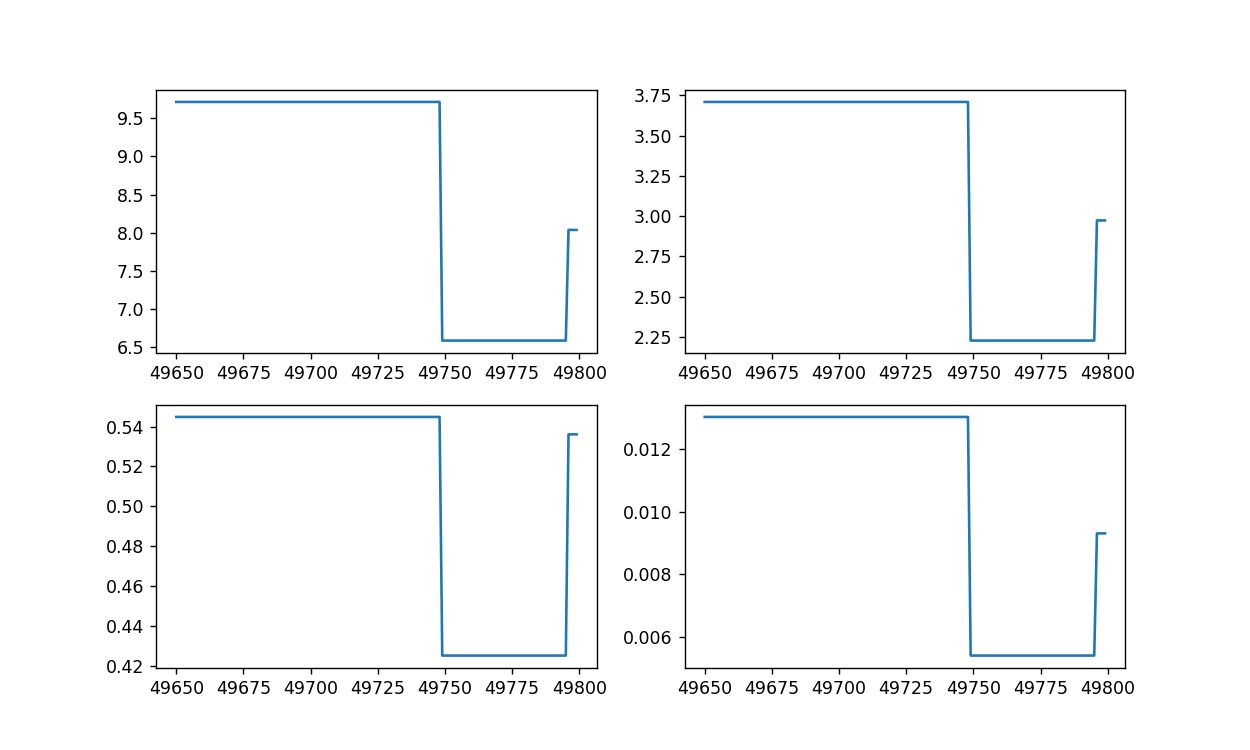

In [195]:
%matplotlib notebook

fig = pyplot.figure(figsize = (10, 6))
ax1 = fig.add_subplot(2, 2, 1)
# ax1.set_ylabel('r')
ax2 = fig.add_subplot(2, 2, 2)
# ax2.set_ylabel('s')
ax3 = fig.add_subplot(2, 2, 3)
# ax3.set_ylabel('t')
ax4 = fig.add_subplot(2, 2, 4)
# ax3.set_ylabel('t')

pyplot.ion()

fig.show()
fig.canvas.draw()

accepted = 0

for i in range(1, M):
    print("{0} / {1}".format(i, M-1), end = "\r")
    # Compute proposal density
    if i < m1:
        if accepted <= 2 * d:
            parametersdensity = { "m" : Parameters[:,i-1], "v" : 0.1 * np.diag(np.repeat(1, d)) }
        else:
            parametersdensity = { "w" : [0.4, 0.5, 0.1], "composition" : [
                {"m" : Parameters[:,i-1], "v" : 0.1 * np.diag(np.repeat(1, d))},
                {"m" : Parameters[:,i-1], "v" : 2.38*2.38/d * np.cov(Parameters[:,range(i)])},
                {"m" : Parameters[:,i-1], "v" : 5 * 2.38*2.38/d * np.cov(Parameters[:,range(i)])} ] }
    if i in sequence:
        # Update proposal at predetermined iterations
        parametersdensity = proposeddensity(Parameters[:,range(i-1)])
    
    # generate proposal
    PropPars[:, i] = mixturerandom(mixture = parametersdensity)
    PF_LL, PF_NL = ParticleFilters(y = Y, p = PropPars[:,i], N = N, model = model)
    PropLL[:,i] = PF_LL
    PropPriorLP[:,i] = prior(PropPars[:,i])
    PropGenLP[:,i] = mixturedensity(PropPars[:,i], parametersdensity)
    
    # PropLL = p( y_{1:t} | proposed parameter )
    # LL = p( y_{1:t} | parameter at previous time )
    # PropPriorLP = pi( proposed parameter )
    # PriorLP = pi( parameter at previous time )
    # PropGenLP = g( proposed parameter | parameter at previous time )
    # GenLP = g( parameter at previous time | proposed parameter )
    
    # accept or reject proposal
    if np.log(np.random.random(size = 1)) < (PropLL[:,i]-LL[:,i - 1]) + (PropPriorLP[:,i]-PriorLP[:,i - 1]) - (i > m1) * (PropGenLP[:,i]-GenLP[:,i-1]):
        # print("accepted")
        Parameters[:,i] = PropPars[:, i]
        LL[:,i] = PropLL[:,i]
        PriorLP[:,i] = PropPriorLP[:,i]
        GenLP[:,i] = PropGenLP[:,i]
        accepted += 1
    else:
        # print("rejected")
        Parameters[:, i] = Parameters[:, i - 1]
        LL[:,i] = LL[:,i - 1]
        PriorLP[:,i] = PriorLP[:,i - 1]
        GenLP[:,i] = GenLP[:,i - 1]
    
    if i % 200 == 0:
        ax1.clear()
        ax2.clear()
        ax3.clear()
        ax4.clear()
        ax1.plot(range(i-150, i), Parameters[0,(i-150):i])
        ax2.plot(range(i-150, i), Parameters[1,(i-150):i])
        ax3.plot(range(i-150, i), Parameters[2,(i-150):i])
        ax4.plot(range(i-150, i), Parameters[3,(i-150):i])
        fig.canvas.draw()


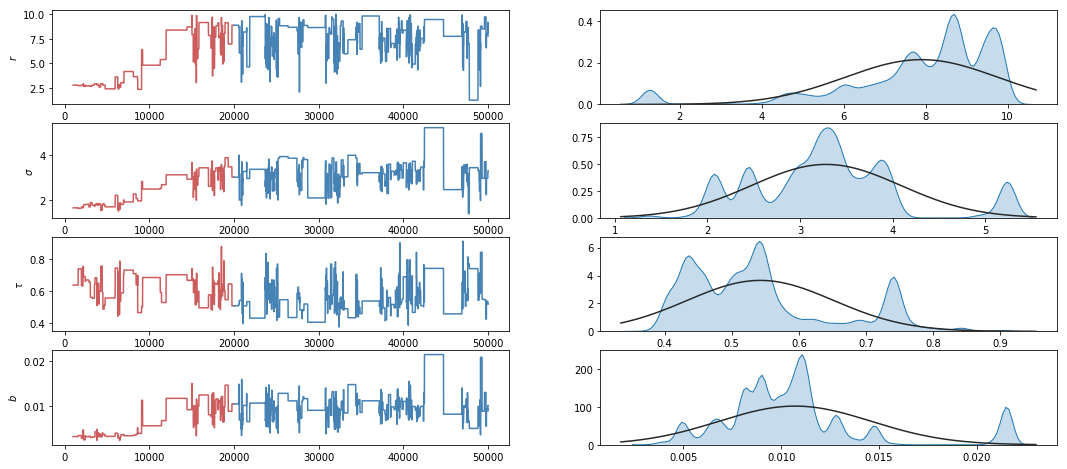

In [203]:
%matplotlib inline
fig = pyplot.figure(figsize = (18, 8))

s = 1000

r_ = Parameters[0,m2:]
sigma_ = Parameters[1,m2:]
tau_ = Parameters[2,m2:]
b_ = Parameters[3,m2:]

pyplot.subplot(4,2,1)
pyplot.plot(range(s,m2), Parameters[0,s:m2], color = "indianred")
pyplot.plot(range(m2,M), r_, "steelblue")
pyplot.ylabel(r"$r$")

pyplot.subplot(4,2,2)
sns.distplot(r_, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 1},
                fit = stats.norm)

pyplot.subplot(4,2,3)
pyplot.plot(range(s,m2), Parameters[1,s:m2], color = "indianred")
pyplot.plot(range(m2,M), sigma_, "steelblue")
pyplot.ylabel(r"$\sigma$")

pyplot.subplot(4,2,4)
sns.distplot(sigma_, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 1},
                fit = stats.norm)

pyplot.subplot(4,2,5)
pyplot.plot(range(s,m2), Parameters[2,s:m2], color = "indianred")
pyplot.plot(range(m2,M), tau_, "steelblue")
pyplot.ylabel(r"$\tau$")

pyplot.subplot(4,2,6)
sns.distplot(tau_, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 1},
                fit = stats.norm)

pyplot.subplot(4,2,7)
pyplot.plot(range(s,m2), Parameters[3,s:m2], color = "indianred")
pyplot.plot(range(m2,M), b_, "steelblue")
pyplot.ylabel(r"$b$")

pyplot.subplot(4,2,8)
sns.distplot(b_, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 1},
                fit = stats.norm)

pyplot.show()